Task: Above, we show the complete dataset for both the ETF and the underlying index (scaled) and some summary statistics. How would you harness the additional historical data available through the underlying index to calculate expected returns of the ETF more accurately?

Files: 
    
- AAXJ.csv
- NDUECAXJ.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

plt.rcParams["figure.figsize"] = (10, 6)

aaxj = pd.read_csv('csv/AAXJ.csv')
msci = pd.read_csv('csv/NDUECAXJ.csv') 

## Exploratory analysis

ETFs track — hold the same proportion of assets as — the underlying index.

"Insufficient historical data" of the ETF (AAXJ) can be interpolated from the underlying index (MSCI) from the period before Aug 2008.

In [2]:
aaxj.columns = ['date', 'close']
msci.columns = ['date', 'close']

df = pd.merge(msci, aaxj, how='outer', on='date')
df.columns = ['date', 'msci', 'aaxj']
df.set_index('date')

,msci,aaxj
date,,
Dec-2000,100.000,NaN
Jan-2001,112.872,NaN
Feb-2001,107.526,NaN
Mar-2001,95.302,NaN
Apr-2001,95.441,NaN
...,...,...
Jun-2020,485.266,85.375
Jul-2020,526.496,92.373
Aug-2020,545.181,95.977


Plot both time series to see how they are related.

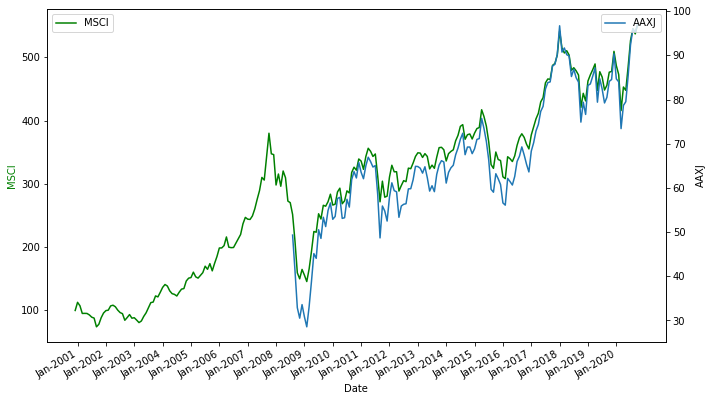

In [3]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('MSCI', color='green')
ax1.plot(df['date'], df['msci'], color='green')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('AAXJ')  # we already handled the x-label with ax1
ax2.plot(df['date'], df['aaxj'])

fig.tight_layout()  # otherwise the right y-label is slightly clipped

ax1.legend(labels=['MSCI'], loc='upper left')
ax2.legend(labels=['AAXJ'], loc='upper right')
plt.xticks(np.arange(1, 240, 12), rotation=90)
fig.autofmt_xdate()
plt.show()

In [4]:
aaxj.corrwith(msci, axis=0)

close    0.774744
dtype: float64

Decompose the time series to confirm.

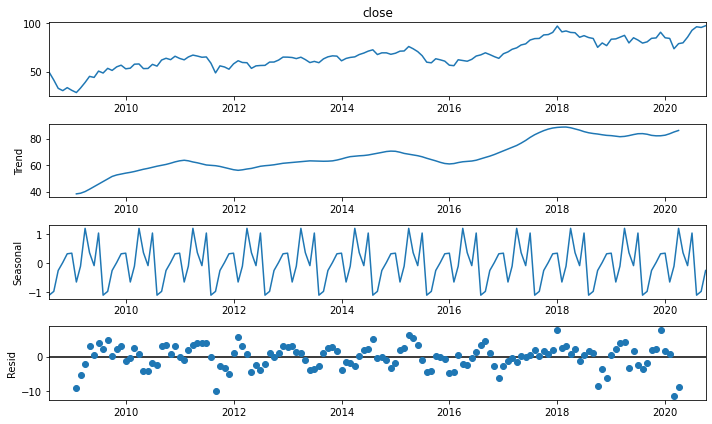

In [5]:
aaxj.reset_index(inplace=True)
aaxj['date'] = pd.to_datetime(aaxj['date'])
aaxj = aaxj.set_index('date')

s = seasonal_decompose(aaxj.close, model='additive')
s.plot()
plt.show()

## Interpolate AAXJ historical data



In [6]:
df.loc[df["aaxj"].isnull(),'aaxj'] = 0.2 * df['msci']

aaxj_p = df.drop(columns=['msci'])

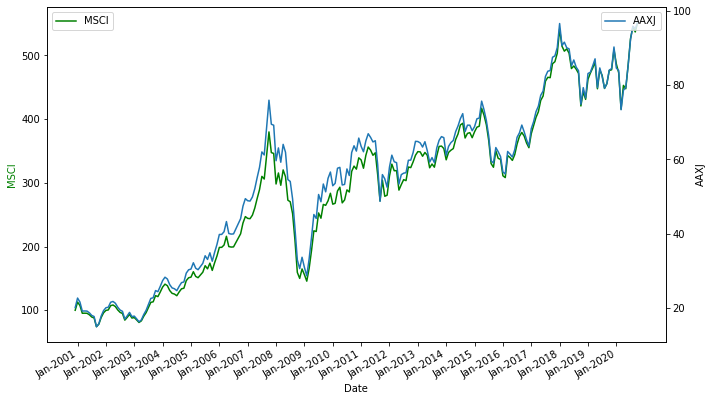

In [7]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('MSCI', color='green')
ax1.plot(df['date'], df['msci'], color='green')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('AAXJ')  # we already handled the x-label with ax1
ax2.plot(df['date'], aaxj_p['aaxj'])

fig.tight_layout()  # otherwise the right y-label is slightly clipped

ax1.legend(labels=['MSCI'], loc='upper left')
ax2.legend(labels=['AAXJ'], loc='upper right')
plt.xticks(np.arange(1, 239, 12), rotation=90)
fig.autofmt_xdate()

plt.show()

In [8]:
aaxj_p.describe()

,aaxj
count,239.000000
mean,54.045781
std,22.210091
min,14.832600
25%,32.948000
50%,59.130000
75%,68.761300
max,97.014000


## Time series forecasting (ARIMA)

Find a f(x) that best explains the historical trends.

Considering that we have a larger dataset (239 data points vs 147 original data points) we can expect any forecasting to be more accurate, all other things being equal. 

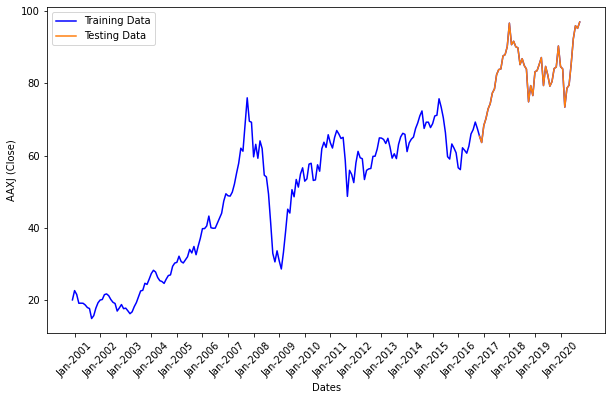

In [9]:
train_data, test_data = aaxj_p[0:int(len(aaxj_p)*0.8)], aaxj_p[int(len(aaxj_p)*0.8):]

plt.xlabel('Dates')
plt.ylabel('AAXJ (Close)')
plt.plot(aaxj_p['aaxj'], 'b', label='Training Data')
plt.plot(test_data['aaxj'], 'tab:orange', label='Testing Data')
plt.xticks(np.arange(1, 240, 12), aaxj_p['date'][1:240:12], rotation=45)
plt.legend()

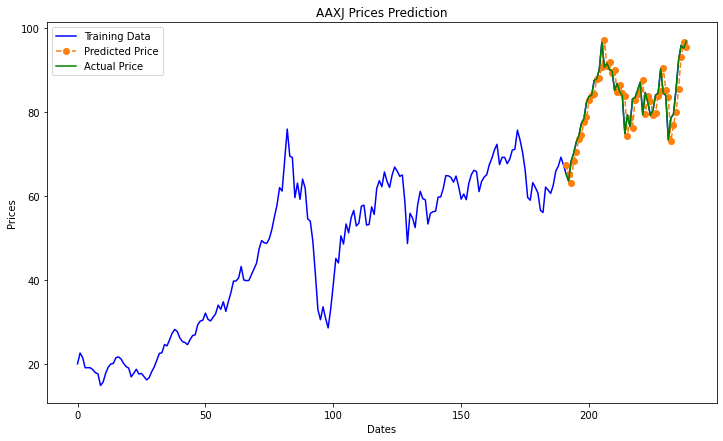

In [10]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

train_ar = train_data['aaxj'].values
test_ar = test_data['aaxj'].values

history = [x for x in train_ar]
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)   
    
error = mean_squared_error(test_ar, predictions)
error2 = smape_kun(test_ar, predictions)

plt.figure(figsize=(12,7))

plt.plot(aaxj_p['aaxj'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='tab:orange', marker='o', linestyle='dashed', label='Predicted Price')
plt.plot(test_data.index, test_data['aaxj'], color='g', label='Actual Price')

plt.title('AAXJ Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
# plt.xticks(np.arange(0, 239, 12), test_data['date'], rotation=45)
plt.legend()

In [11]:

print(type(history))
print('predicted=%f, expected=%f' % (yhat, obs))

print('Testing Mean Squared Error: %.3f' % error)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
predicted=95.533023, expected=97.014000
Testing Mean Squared Error: 16.251
Symmetric mean absolute percentage error: 3.841


---

## References

1. https://stackoverflow.com/questions/65336789/numpy-build-fail-in-m1-big-sur-11-1
1. https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html
1. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/